### Import

In [1]:
import copy
import datetime
import joblib
from collections import defaultdict
from tqdm import tqdm; tqdm.pandas()
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from pytorch_model_summary import summary

from rawdata import RawData, Preprocess
from data import DataInfo, Dataset, collate_fn
from data import LogScaler, NoneScaler, CustomLabelEncoder

device = torch.device("cuda")

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [2]:
test_mode = False

# Raw data
is_raw_data_exist = True
is_prep_data_exist = True

# Data loader
MIN_MEANINGFUL_SEQ_LEN = 100
MAX_SEQ_LEN = 365
PRED_LEN = 100
modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["day", "dow", "month", "holiday", "price"],
    "img": ["img_path"],
    "others": ["sales_channel_id", "prod_name", "product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]
}
processing_info = {
    "scaling_cols": {"sales": LogScaler, "price": MinMaxScaler},
    "embedding_cols": ["sales_channel_id", "day", "dow", "month", "holiday",
                        "prod_name", "product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"],
    "img_cols": ["img_path"]
}


modality_info = {
    "group": ["article_id", "sales_channel_id"],
    "target": ["sales"],
    "temporal": ["day", "dow", "month", "holiday", "price"],
    "img": [],
    "others": ["sales_channel_id", "prod_name", "product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]
}
processing_info = {
    "scaling_cols": {"sales": LogScaler, "price": MinMaxScaler},
    "embedding_cols": ["sales_channel_id", "day", "dow", "month", "holiday",
                        "prod_name", "product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"],
    "img_cols": []
}


# Model
batch_size = 16
target_batch_size = 64
grad_accm_step_max = target_batch_size // batch_size

d_model = {"encoder":128, "decoder":128}
nhead = 4
d_ff = {"encoder":256, "decoder":256}
dropout = 0.1
num_layers = {"encoder":4, "decoder":2}

remain_rto = {"general": 0.25, "cat":0.25}

patch_size = 14

# Data

### Raw data

In [3]:
if not is_prep_data_exist:
    rawdata = RawData()
    df_trans, df_meta, df_holiday = rawdata.get_raw_data(is_raw_data_exist=True)
    preprocess = Preprocess(df_trans, df_meta, df_holiday)
    df_preprocessed = preprocess.main()
else:
    df_preprocessed = pd.read_parquet("src/df_preprocessed.parquet")

if test_mode:
    df_preprocessed = df_preprocessed.iloc[:1000]

### Dataset

In [4]:
df_train = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1)]
df_valid = df_preprocessed[(df_preprocessed["meaningful_size"] >= MIN_MEANINGFUL_SEQ_LEN) & (df_preprocessed["time_idx"] <= MAX_SEQ_LEN-1 + PRED_LEN)]

data_info = DataInfo(modality_info, processing_info)

{'group': ['article_id', 'sales_channel_id'], 'target': ['sales'], 'temporal': ['day', 'dow', 'month', 'holiday', 'price'], 'img': [], 'others': ['sales_channel_id', 'prod_name', 'product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name']}


In [5]:
train_dataset = Dataset(df_train, data_info, remain_rto["general"])
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info), pin_memory=True, num_workers=16, prefetch_factor=4)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info))

valid_dataset = Dataset(df_valid, data_info, remain_rto["general"], is_train=False, label_encoder_dict=train_dataset.label_encoder_dict)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: collate_fn(x, data_info))

if True:
    for data in train_dataloader:
        for key in data.keys():
            if "img_raw" not in key:
                print(key, data[key].shape)
        break

    # for _ in valid_dataloader:
    #     break

100%|██████████| 29388/29388 [00:01<00:00, 21268.40it/s]

sales torch.Size([16, 365, 1])
sales_remain_idx torch.Size([16, 91])
sales_masked_idx torch.Size([16, 274])
sales_revert_idx torch.Size([16, 365])
day torch.Size([16, 365])
day_remain_idx torch.Size([16, 91])
day_masked_idx torch.Size([16, 274])
day_revert_idx torch.Size([16, 365])
dow torch.Size([16, 365])
dow_remain_idx torch.Size([16, 91])
dow_masked_idx torch.Size([16, 274])
dow_revert_idx torch.Size([16, 365])
month torch.Size([16, 365])
month_remain_idx torch.Size([16, 91])
month_masked_idx torch.Size([16, 274])
month_revert_idx torch.Size([16, 365])
holiday torch.Size([16, 365])
holiday_remain_idx torch.Size([16, 91])
holiday_masked_idx torch.Size([16, 274])
holiday_revert_idx torch.Size([16, 365])
price torch.Size([16, 365, 1])
price_remain_idx torch.Size([16, 91])
price_masked_idx torch.Size([16, 274])
price_revert_idx torch.Size([16, 365])
temporal_remain_padding_mask torch.Size([16, 91])
temporal_masked_padding_mask torch.Size([16, 274])
temporal_revert_padding_mask torch.Si

# Train

### Model

In [6]:
from architecture import Transformer

model = Transformer(data_info, train_dataset.label_encoder_dict, patch_size,
                        d_model, num_layers, nhead, d_ff, dropout)
model.to(device)
summary(model, data, remain_rto, device, show_parent_layers=True, print_summary=True)

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


------------------------------------------------------------------------------------------------------------------------------------------------------
   Parent Layers            Layer (type)                                                                  Output Shape         Param #     Tr. Param #
     Transformer             Embedding-1                                                                     [14, 128]           1,792           1,792
     Transformer          OthersRemain-2                                                                  [16, 4, 128]             128             128
     Transformer             Embedding-3                                                                  [16, 4, 128]             896             896
     Transformer               Encoder-4                                             [16, 556, 128], [16, 4, 556, 556]         529,920         529,920
     Transformer                Linear-5                                                      

'------------------------------------------------------------------------------------------------------------------------------------------------------\n   Parent Layers            Layer (type)                                                                  Output Shape         Param #     Tr. Param #\n======================================================================================================================================================\n     Transformer             Embedding-1                                                                     [14, 128]           1,792           1,792\n     Transformer          OthersRemain-2                                                                  [16, 4, 128]             128             128\n     Transformer             Embedding-3                                                                  [16, 4, 128]             896             896\n     Transformer               Encoder-4                                             [1

### Train

sales_channel_id - 	 y: 2.0 	 pred:2.0
prod_name - 	 y: KARIN MID SUPPORT BRA 	 pred:Despacito
product_type_name - 	 y: Bra 	 pred:Trousers
product_group_name - 	 y: Underwear 	 pred:Garment Upper body
graphical_appearance_name - 	 y: All over pattern 	 pred:Solid
colour_group_name - 	 y: Dark Green 	 pred:Black
perceived_colour_value_name - 	 y: Dark 	 pred:Dark
perceived_colour_master_name - 	 y: Green 	 pred:Black
department_name - 	 y: Ladies Sport Bras 	 pred:Jersey
index_name - 	 y: Sport 	 pred:Ladieswear
index_group_name - 	 y: Sport 	 pred:Ladieswear
section_name - 	 y: Ladies H&M Sport 	 pred:Womens Everyday Collection
garment_group_name - 	 y: Jersey Fancy 	 pred:Jersey Fancy


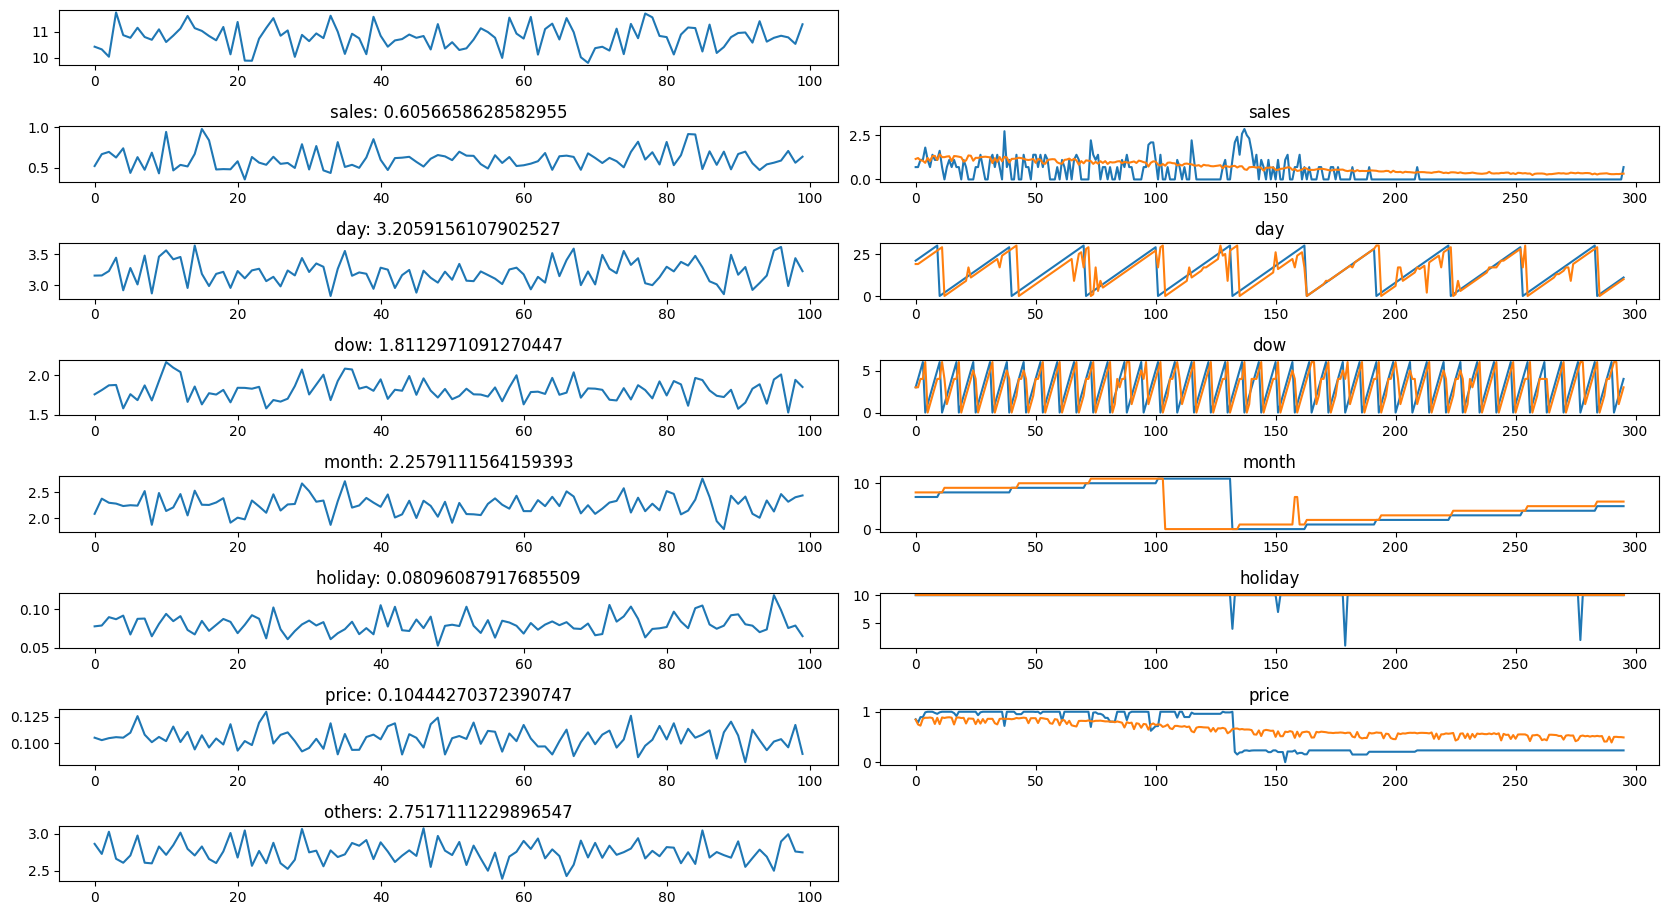

3 - loss: 10.799310483932494, lr: [0.00099778098230154]:  40%|███▉      | 733/1837 [00:46<01:13, 14.97it/s]

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
mse_loss = torch.nn.MSELoss(reduction="none")
ce_loss = torch.nn.CrossEntropyLoss(reduction="none")
max_norm = 1

def temporal_loss(col, pred, y, masked_idx, padding_mask=None):
    masked_idx = masked_idx.to(device)
    padding_mask = padding_mask.to(device)
    
    if col in data_info.processing_info["scaling_cols"]:
        pred = pred[:, 1:, :].squeeze()
        pred = torch.gather(pred, index=masked_idx, dim=1)
        
        y = y.squeeze().to(device)
        y = torch.gather(y, index=masked_idx, dim=1)

        loss = mse_loss(pred, y)
        loss = torch.where(padding_mask == 1, loss, 0)
        loss = loss.sum() / padding_mask.sum()
    
    elif col in data_info.processing_info["embedding_cols"]:
        pred_masked_idx = masked_idx.unsqueeze(-1).repeat(1, 1, pred.shape[-1])
        pred = pred[:, 1:, :]
        pred = torch.gather(pred, index=pred_masked_idx, dim=1)

        y = y.to(device).to(torch.long)
        y = torch.gather(y, index=masked_idx, dim=1)

        loss = ce_loss(pred.view(-1, pred.shape[-1]), y.view(-1))
        loss = loss.view(y.shape)
        loss = torch.where(padding_mask == 1, loss, 0)
        loss = loss.sum() / padding_mask.sum()

    return loss

def others_loss(pred, y):
    loss = ce_loss(pred, y.to(device).to(torch.long))
    return loss

def train(e):
    pbar = tqdm(train_dataloader)
    loss_li_dict, loss_li, window, grad_accm_step = defaultdict(list), [], 100, 0
    optimizer.zero_grad()

    for n, data in enumerate(pbar):
        model.train()
        output, others_idx_dict = model(data, remain_rto, device)
        loss_dict = {}
        # Temporal loss
        st = datetime.datetime.now()
        for col in data_info.modality_info["target"] + data_info.modality_info["temporal"]:
            loss  = temporal_loss(col, output[col], data[col], data[f"{col}_masked_idx"], data["temporal_masked_padding_mask"])
            loss_dict[col] = loss
            loss_li_dict[col].append(loss.item())
        
        # Ohters loss
        st = datetime.datetime.now()
        others_loss_li = []
        for col in data_info.modality_info["others"]:
            loss = others_loss(output[col], data[col])
            others_loss_li.append(loss)
        others_loss_li = torch.stack(others_loss_li, dim=1)
        masked_idx = others_idx_dict["others_masked_idx"]
        
        loss = torch.gather(others_loss_li, index=masked_idx, dim=1)
        loss = torch.mean(loss)
        loss_dict["others"] = loss
        loss_li_dict["others"].append(loss.item())
        
        # Sum loss
        st = datetime.datetime.now()
        loss = torch.nansum(torch.stack(list(loss_dict.values()))) / grad_accm_step_max
        
        loss.backward()
        grad_accm_step += 1

        if grad_accm_step == grad_accm_step_max:
            st = datetime.datetime.now()
            loss_li.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            grad_accm_step = 0
            # print("grad_accm_step:", datetime.datetime.now()-st)
        
        msg = f"{e} - loss: {np.nanmean(loss_li[-window:])}, lr: {scheduler.get_last_lr()}"
        pbar.set_description(msg)
        
        if n % (grad_accm_step_max*20) == 0:
            idx = 0
            plt.figure(figsize=(25,23))
            nrows, ncols = 20, 3
            plot_idx = 1
            clear_output(wait=True)

            # Loss
            plt.subplot(nrows, ncols, plot_idx)
            plt.plot(loss_li[-window:])
            plot_idx += 2

            # Temporal samples
            for col in data_info.modality_info["target"] + data_info.modality_info["temporal"]:
                # Loss
                plot_idx += 1
                plt.subplot(nrows, ncols, plot_idx)
                plt.plot(loss_li_dict[col][-window:])
                plt.title(f"{col}: {np.mean(loss_li_dict[col][-window:])}")

                # Sample
                plot_idx += 1
                plt.subplot(nrows, ncols, plot_idx)

                valid_len = data["temporal_revert_padding_mask"][idx].min(-1).indices
                valid_len = MAX_SEQ_LEN if valid_len==0 else valid_len

                y = data[col][idx][:valid_len].squeeze()
                pred = output[col][idx].detach().cpu()[:valid_len].squeeze()
                    
                if col in data_info.processing_info["embedding_cols"]:
                    pred = torch.argmax(pred, dim=-1)
                
                plt.plot(y, label="y")
                plt.plot(pred, label="pred")
                plt.title(col)

                # Attention weight
                plot_idx += 1
            
            # Others samples
            # Loss
            plot_idx += 1
            plt.subplot(nrows, ncols, plot_idx)
            plt.plot(loss_li_dict["others"][-window:])
            plt.title(f'others: {np.mean(loss_li_dict["others"][-window:])}')
            for col in data_info.modality_info["others"]:
                others_output = torch.argmax(output[col], dim=-1)[idx].detach().cpu().numpy().tolist()
                others_output = train_dataset.label_encoder_dict[col].inverse_transform(others_output)
                
                others_y = data[col][idx].numpy().tolist()
                others_y = train_dataset.label_encoder_dict[col].inverse_transform(others_y)
                print(f"{col} - \t y: {others_y} \t pred:{others_output}")

            
            plt.tight_layout()
            plt.show()

epoch = 10
for e in range(epoch):
    train(e)
    scheduler.step()

# Eval

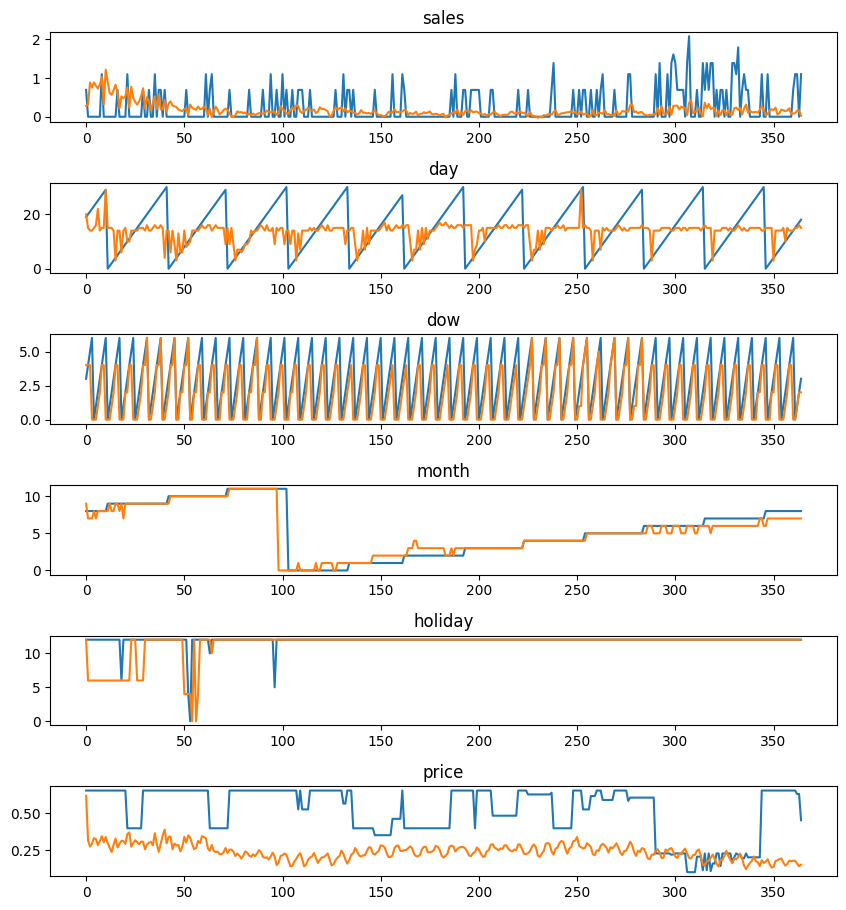

In [ ]:
model.eval()
pbar = tqdm(valid_dataloader)

for n, data in enumerate(pbar):
    with torch.no_grad():
        output, _ = model(data, remain_rto, device)

    idx = 0
    plt.figure(figsize=(25,15))
    nrows, ncols = 10, 3
    plot_idx = 1
    clear_output(wait=True)

    # Temporal samples
    for col in data_info.modality_info["target"] + data_info.modality_info["temporal"]:
        plot_idx += 1
        # Sample
        plot_idx += 1
        plt.subplot(nrows, ncols, plot_idx)

        valid_len = data["temporal_revert_padding_mask"][idx].min(-1).indices
        valid_len = MAX_SEQ_LEN if valid_len==0 else valid_len

        # print(data[col].shape)
        # print(data[col][idx, :, :].shape)
        # print("_"*100)
        y = data[col][idx][:valid_len].squeeze()
        pred = output[col][idx].detach().cpu()[:valid_len].squeeze()
            
        if col in data_info.processing_info["embedding_cols"]:
            pred = torch.argmax(pred, dim=-1)
        
        plt.plot(y, label="y")
        plt.plot(pred, label="pred")
        plt.title(col)

        # Attention weight
        plot_idx += 1

    
    plt.tight_layout()
    plt.show()
    input()